## FWL Theorem and Double Machine Learning


Following up on the previous notebook where we covered several doubly robust methods (e.g., AIPW and TMLE), we will go through double machine learning (DML) in detail in this notebook. But before diving into theory let us understand why we need DML in the first place, shall we?

Augmented inverse propensity weighting (AIPW) is a modification of the inverse propensity weighting (IPW) that guarantees double roubustness and consistent average treatment effect(ATE) estimate even if 1) treatment/exposure model ($ \hat\pi(x) $) or 2) outcome model ($ \hat\mu(x) $) is misspecified [GLynn and Quinn, 2009](https://www.law.berkeley.edu/files/AIPW(1).pdf). Although AIPW provides a nice flexibility in estimating a consistent ATE, it does necessitate at least one model to be correctly specified. If both the models are incorrectly specified, the naive IPW outperforms AIPW. Similarly, targeted maximum likelihood estimation (TMLE) is a semiparametric estimation framework. TMLE tends to work well when the treatment is not a weak predictor of the outcome. If that's not the case, the estimation tends to be biased toward zero which obviously might not be the baseline truth. 

The main objective of DML is to provide a general framework to estimating and performing inference on low-dimensional parameter ($ \theta_0$) in presence of high-dimensional nuisance parameter utilizing nonparametric machine learning methods. DML works for both binary and continuous treatment variables which is not the case for some of the doubly robust methods. As the name suggests, DML leverages "double" or two high-performance ML methods to estimate a high-quality $\theta_0$. Specifically, the first ML algorithm is used for treatment model while the second algorithm is used for the outcome model. Finally, Frisch-Waugh-Lovell (FWL)-type residuals-on-residuals regressioin is utilized to get a de-biased estimate of $\theta_0$. DML is also know as "debiased-ML" or "orthogonalized ML."

### FWL Theorem/Orthogonalization

Orthogonalization (or equivalently FWL Theorem ([Frisch and Waugh, 1933](https://www.jstor.org/stable/pdf/1907330.pdf); [Lovell, 1963](https://www.tandfonline.com/doi/abs/10.3200/jece.39.1.88-91)) is the backbone of DML. Its principled approach guarantees an unbiased estimate. Since it is a key to understanding why DML works, we will first prove the FWL Theorem and implement it in an example to demonstrate how it debiases the data before moving on to the details of DML.  

Let us take a multivariate linear regression
$$ Y = D_1\beta_1 + X\beta_2 + \epsilon $$
where $Y$ is $ n \times 1$ outcome, $D$ is $n \times p_1$ treatment variables, and $X$ is $n \times p_2$ covariates or nuisance parameters. 

Multiply the equation with residual maker function ($G$) of the treatment parameters $D$. The residual maker is defined by $Gy = y - D(D'D)^{-1}D'y \equiv y - D\beta \equiv \epsilon_D$

$$ GY = GD_1\beta_1 + GX\beta_2 + G\epsilon $$

Since $GD_1\beta_1 \equiv 0$, the equation above simplifies to 

$$ GY = GX\beta_2 + G\epsilon $$

Now, the final equation becomes

$$ GY = GX\beta_2 + \epsilon $$

Taking a closer look at the equation, we can see that we are regressing residuals on residuals. This shows that results obtained from multivariate linear regression is the same as the residuals-on-residuals regression.

Now that we have seen a proof of why residuals-on-residuals regression work, let us go through an example implementation to see orthogonalization in action.

In [1]:
# importing required packages
import os
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

import doubleml as dml
from doubleml.datasets import fetch_401K

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV, LogisticRegressionCV, LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier, XGBRegressor

/Users/sunaybhat/miniconda3/envs/stats256/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.figsize'] = 10., 6

#### Orthogonalization: Example 

To demonstrate how orthogonalization debiases the data, we will use a simulated data on ice cream sales. The outcome ($Y$) is the number of sales, the treatment is price, and the covariates ($X$) are temperature, weekday (categorical variable) and cost of the ice cream.  

In [3]:
df_ortho = pd.read_csv('ice_cream_sales.csv')
df_ortho.head()

,temp,weekday,cost,price,sales
0,17.3,6,1.5,5.6,173
1,25.4,3,0.3,4.9,196
2,23.3,5,1.5,7.6,207
3,26.9,1,0.3,5.3,241
4,20.2,1,1.0,7.2,227


There are no missing data as we can see below:

In [4]:
df_ortho.isna().sum()

temp       0
weekday    0
cost       0
price      0
sales      0
dtype: int64

The figure below shows a heatmap of the Pearsons' correlation plot of the dataset. The correlation plot shows positive linear relationship between three pairs of variables (sales-temp, cost-price, and price-sales)- two of which makes sense, one does not. As the temperature increases, we often expect ice cream sales to increase because people buy more ice cream if it is hot. Similarly, the price of the ice crease will increase if the purchase cost for the vendor is high. However, the third positive correlation is between price and sales which necessarily doesn't make sense because if the price is high, people tend to buy less so if anything, there should be a negative correlation. The positive correlation could potentially because of bias. 

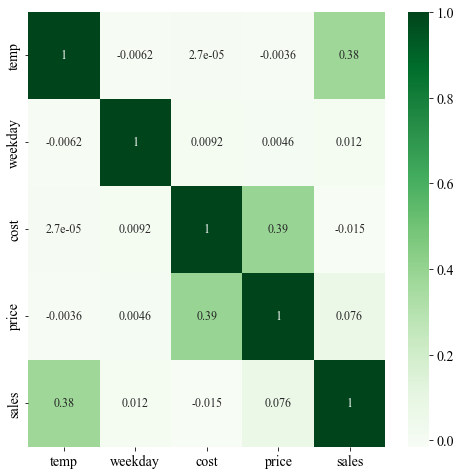

In [5]:
plt.figure(figsize=(8,8))
sns.heatmap(df_ortho.corr(), cmap="Greens",annot=True, annot_kws={"fontsize":'large'})
# plt.savefig('corr_plot_iceCream.png', bbox_inches='tight')
plt.show()

Looking at the scatter plot between sales and price, we can see that the data clearly is biased. First, we can see the two distinct cluster. On weekends, the sales is high because more people go outside which increases the demand. The vendors likely take an advantage of the increased demands and hike up the prices which ultimately reduces the sales. However, the sales appear to be roughly uniform regardless of the price during weekdays. The higher sales on weekends and the consistent sales during weekdays gives a positive relationship between sales and price as shows by a linear fit line (red line) in the figure below. 

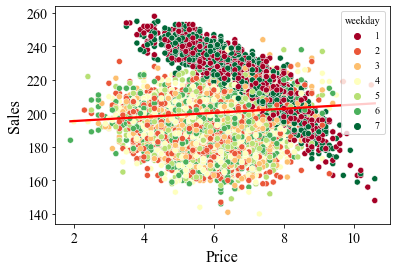

In [6]:
plt.figure()
sns.scatterplot(data=df_ortho, x="price", y="sales", hue="weekday", palette='RdYlGn', legend='full');
sns.regplot(x='price', y='sales', data=df_ortho, scatter=False, ci=False, color ='red')
plt.xlabel('Price', fontsize=16)
plt.ylabel('Sales', fontsize=16)
# plt.savefig('scatter_original_iceCream.png', bbox_inches='tight')
plt.show()

To debiase the data, we need two models- treatment and outcome model. The treatment model debiases the bias induced in price using all the other confounders, while the outcome model debiases the bias in sales introduced by the same covariates. Consistent with FWL Theorem, we used OLS to create the treatment and outcome models as shown below:


In [7]:
#create a treatment model 
model_treatment = smf.ols("price ~ cost + C(weekday) + temp", data=df_ortho).fit()
#create an outcome model
model_outcome = smf.ols("sales ~ cost + C(weekday) + temp", data=df_ortho).fit()

debiased_df_ortho = df_ortho.assign(**{"resid_output_sales":model_outcome.resid,
                                       'resid_treatment_price':model_treatment.resid})

If we plot price-residuals against sales, we can see that we have debiased the bias in price. First, we have uncovered the negative relationship between the price and sales as expected. Most importantly, we can see that decline in sales during the weekend is consistent and not necessarily depending on the price. In the raw data above, we saw that as the price increased, the sales decreased drastically, thus inducing price bias. But in this case, the number of sales on the left and the right side of price-residual roughly appears to be the same. 

Even though we have debiased the price, we can still see that the data has two distinct clusters as a function of the sale day. During weekends, the sales seems to be higher as compared to the weekdays.


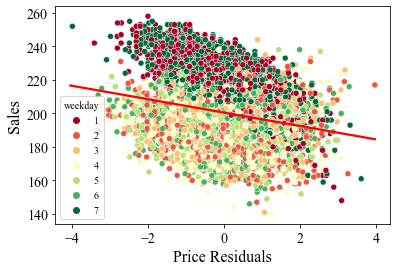

In [8]:
plt.figure()
sns.scatterplot(data=debiased_df_ortho, x="resid_treatment_price", y="sales",
                hue="weekday", palette='RdYlGn', legend='full')
sns.regplot(x='resid_treatment_price', y='sales', data=debiased_df_ortho, scatter=False, ci=False, color ='red')
plt.xlabel('Price Residuals', fontsize=16)
plt.ylabel('Sales', fontsize=16)
# plt.savefig('scatter_priceDebiased_iceCream.png', bbox_inches='tight')
plt.show()

Finally, lets see if we can debiase the bias in sales amount. The figure below plots sales-residuals against price-residuals. We can see that the we no longer have distinct clusters of data neither do we see a dramatic decline in sales as the price increase. The slope of the linear fit line (red line) is the debiased estimated of ATE that is obtained by regressing price-residuals on sales-residuals. 


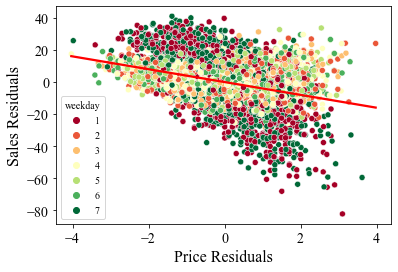

In [9]:
plt.figure()
sns.scatterplot(data=debiased_df_ortho, x="resid_treatment_price", y="resid_output_sales",
                hue="weekday", palette='RdYlGn', legend='full')
sns.regplot(x='resid_treatment_price', y='resid_output_sales', data=debiased_df_ortho,
            scatter=False, ci=False, color ='red')
plt.xlabel('Price Residuals', fontsize=16)
plt.ylabel('Sales Residuals', fontsize=16)
# plt.savefig('scatter_doubleDebiased_iceCream.png', bbox_inches='tight')
plt.show()

This example illustrates the role orthogonalization playing in debiasing the data and more importantly estimating a debiased ATE estimate.

### Debiased/Double Machine Learning

Now that we understand orthogonalization, we will dig a little deeper into DML formulations. Good news is that if you understand the intuition behind orthogonalization, you already understand DML. To simplify, DML is fundamentally the same as orthogonalization except that advanced ML algorithms are used to model treatment and outcome instead of OLS.

One may wonder, ML algorithms are widely used in anything and everything, haven't researchers used to estimate treatment effect? Yes, they have and that's when naive approach comes in. In this section, naive approach refers to methods involving ML methods with no modifications. Since DML is a slighly different class of roubly-robust method in a sense that it utilized ML algorith, we introduce Naive or prediction-based ML approach to make a direct comparison against DML and show why DML is better than the naive approach. 

To be consistent with the [Double/Debiased Machine Learning Paper](https://arxiv.org/abs/1608.00060)(Chernozhukov et al., 2018), we will use the same notations. 



Let us take a partial linear regression, 
$$Y = D\theta_0 + g_0(X) + U, \quad E[U|X, D] = 0 $$


$$D = m_0(X) + V, \quad E[V|X] = 0$$

where $Y$ is the outcome, $D$ is the treatment, $X$ is the covariates/confounders, and $U$ and $V$ are the noise. The quantity of interest is the regression coefficient, $\theta_0$.

Under naive approach, the following steps are undertaken to estimate the $\theta_0$

1. Predict $Y$ using $D$ and $X$. This gives you $\hat Y$ in the form of $D\hat\theta_0 + \hat g_0(X)$


2. Run advanced ML algorithm (e.g., Random Forest) of $Y - D\hat\theta_0$ on $X$ to fit $\hat g_0(X)$


3. Run OLS of $Y - \hat g_0(X)$ on $D$ to fit $\hat\theta_0$. In other words, $\hat\theta_0$ is given by: 

$$ \hat\theta_0 = \left( \frac{1}{n} \sum_{i \in I} D_i^2 \right)^{-1} \frac{1}{n} \sum_{i \in I}D_i(Y_i - \hat g(X_i)) $$

The naive approach displays excellent predictive performance but introduces a regularization bias in learning $g_0$. Lets take a closer look at the decomposition of the estimation error in $\hat\theta_0$ to islolate the regularization bias, 

$$\sqrt{n}(\hat\theta_0 - \theta_0) = \underbrace{\left( \frac{1}{n} \sum_{i \in I} D_i^2 \right)^{-1} \frac{1}{\sqrt{n}} \sum_{i \in I} D_i U_i}_{:a} + \underbrace{\left( \frac{1}{n} \sum_{i \in I} D_i^2 \right)^{-1} \frac{1}{\sqrt{n}} \sum_{i \in I} D_i(g_0(X_i) - \hat g_0(X_i))}_{:b}$$
    

The first term $a$ is well-behaved under mild conditions and has zero mean $a \rightsquigarrow N(0, \bar\Sigma)$ for some $\bar\Sigma$. However, the regularization term ($b$) does not center around 0, and in fact diverges for the majority of the ML algorithms. The regularization bias is addressed using orthogonalization. How exactly does DML do it? Using the following three steps: 

1. Predict $Y$ and $D$ using $X$ using the advanced ML methods to obtain $\widehat{E[Y|X]}$ and $\widehat{E[D|X]}$


2. Obtain residuals from the two models i.e. $\widehat{W} = Y -\widehat{E[Y|X]}$ and $\widehat{V} = D -\widehat{E[D|X]}$


3. Use orthogonalization, i.e. regress $\widehat{W}$ on $\widehat{V}$ to get $\hat\theta_0$


In DML, the estimation error in $\hat\theta_0$ can be decomposed into 

$$\sqrt{n}(\hat\theta_0-\theta_0) = a^* + b^* + c^*$$

where, 
$$a^* = (EV^2)^{-1}\frac{1}{\sqrt{n}}\sum_{i \in I}V_iU_i \rightsquigarrow N(0, \Sigma),$$


$$b^* = (EV^2)^{-1}\frac{1}{\sqrt{n}}\sum_{i \in I}(\hat m_0(X_i) - m_0(X_i))(\hat g_0(X_i) - g_0(X_i)) $$

and, 

$$ c^*  = o_P(1)$$

Similar to naive approach, $a^*$ has a zero mean. The second term, $b^*$ also nearly as zero mean because the the high predictive performance of advanced ML algorithms ensure that the product of the estimation error in $\hat m_0$ and $\hat g_0$ nearly vanishes to zero. The $c^*$ term represents bias induced due to overfitting, which is sufficiently well-behaved and vanishes in probability under sample splitting. For DML to be doubly robust, it is paramount to split the data into multiple folds while estimating $\hat\theta_0$. For a detailed proof on why $c^*$ vanishes in probability in presence of sample splitting, we invite readers to read the [Double/Debiased Machine Learning Paper](https://arxiv.org/abs/1608.00060).

#### DML: Example Implementation


In this example, we will use the data on 401(k) eligibility (treatment variable) on the total accumulated net financial assess (net_tfa). This dataset was assembled from the 1991 Survey of Income and Porgram Participation. Since the assignment was not random, the DML is implemented to negate bias due to non-randomness assignment. 

In [10]:
df_401k = fetch_401K(return_type='DataFrame')
df_401k.sample(n=5)

,nifa,net_tfa,tw,age,inc,fsize,educ,db,marr,twoearn,e401,p401,pira,hown
9567,35413.0,53322.0,86782.0,36,89727.0,2,18,1,1,1,1,1,1,1
4037,257.0,257.0,20257.0,46,11901.0,7,6,0,1,1,0,0,0,1
2201,3380.0,-2320.0,-1520.0,26,35493.0,4,12,0,1,1,0,0,0,0
5512,700.0,700.0,47175.0,38,18900.0,2,12,0,0,0,0,0,0,1
1053,318.0,318.0,318.0,42,36840.0,4,16,0,1,1,0,0,0,0


The description of the features are highlighted below:

1. __age:__ age of the employee
2. __inc:__ income amount 
3. __fsize:__ family size 
4. __educ:__ years of education
5. __marr:__ marriage indicator (1: married, 0: otherwise) 
6. __twoearn:__ two-earner status indicator in the family 
7. __db:__ a defined benefit pension status indicator 
8. __pira:__ an IRA participation indicator 
9. __hown:__ a home ownership indicator 
10. __net_tfa:__ net total financial assets. Defined as the sum fo IRA balances, 401(k) balances, checking accounts, U.S. saving bonds, stocks, mutual funds, etc.

As discussed below, we will not use all of the features in this example.

In [11]:
df_401k.shape

(9915, 14)

Difference in mean between the employees who were eligible vs not eligible.

In [12]:
df_401k.groupby('e401')['net_tfa'].mean()

e401
0    10788.044922
1    30347.388672
Name: net_tfa, dtype: float32

Difference in mean between the employees who opted to participate in 401(k) vs those that did not participate.

In [13]:
df_401k.groupby('p401')['net_tfa'].mean()

p401
0    10890.477539
1    38262.058594
Name: net_tfa, dtype: float32

For consistency, we will use the same covariates used in the [Double/Debiased Machine Learning Paper](https://arxiv.org/abs/1608.00060).

In [14]:
features_cherno = [ 'age', 'inc', 'fsize', 'educ', 'marr', 'twoearn', 'db', 'pira', 'hown']

In [15]:
#outcome model 
my = smf.ols('net_tfa ~ ' + '+'.join(features_cherno), data = df_401k).fit()

#treatment model
mt = smf.ols('e401 ~  ' + '+'.join(features_cherno), data = df_401k).fit()

One of the limitations we have not mentioned before is that the orthogonalization is limited to linear relationship between the covariates, treatment, and outcome models. Of course, the linear regression can be extended to a polynomial regression to capture nonlinear relationship but having to specify the nonlinear functional form is not that flexible and desirable. We implement linear and polynomial regression to shed light on the high-level predictive performance of commonly used ML algorithms. 

In [16]:
orthogonal = smf.ols("tfa_res~e401_res", 
        data=df_401k.assign(tfa_res=my.resid, # sales residuals
                          e401_res=mt.resid) # price residuals
       ).fit()
orthogonal.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.19e-09,559.394,3.91e-12,1.000,-1096.527,1096.527
e401_res,5896.1984,1249.446,4.719,0.000,3447.029,8345.367


In [17]:
## creating a dummy dataframe for easy data parsing 
dummydf = pd.DataFrame(orthogonal.summary().tables[1])

d = {'coef': orthogonal.params['e401_res'],
     'std err':dummydf[2][2],
     '2.5 %':dummydf[5][2],
     '97.5 %':dummydf[6][2]}
df_linear = pd.DataFrame([d])
df_linear.head()

,coef,std err,2.5 %,97.5 %
0,5896.198421,1249.446,3447.029,8345.367


Creating a polynomial regression

In [18]:
my_poly = smf.ols('net_tfa ~ age + inc + educ + fsize + marr + twoearn + db + pira + hown + age*fsize + educ*age + fsize**2',
                  data = df_401k).fit()
mt_poly = smf.ols('e401 ~ age + inc + educ + fsize + marr + twoearn + db + pira + hown', data = df_401k).fit()

In [19]:
polynomial = smf.ols("tfa_res~e401_res", 
        data=df_401k.assign(tfa_res=my_poly.resid, # sales residuals
                          e401_res=mt_poly.resid) # price residuals
       ).fit()

As we can see, for the polynomial regression, the estimated ATE is slighly higher by about $200 as compared to OLS. This indicates that the data is highly nonlinear and we can leverage the ML algorithms to capture the nonlinear relationship. 

In [20]:
dummydf = pd.DataFrame(polynomial.summary().tables[1])

d = {'coef': polynomial.params['e401_res'],
     'std err':dummydf[2][2],
     '2.5 %':dummydf[5][2],
     '97.5 %':dummydf[6][2]}
df_polynomial = pd.DataFrame([d])
df_polynomial.head()

,coef,std err,2.5 %,97.5 %
0,6084.770503,1247.310,3639.789,8529.752


In [21]:
# Initialize DoubleMLData (data-backend of DoubleML)
data_dml_base = dml.DoubleMLData(df_401k,
                                 y_col='net_tfa',
                                 d_cols='e401',
                                 x_cols=features_cherno)

In the following section, Random Forest, Xtreme Gradient Boosting (XGBoost), and Regression trees are implemented to estimate the ATE in terms of the total financial asset. Two variations of implementation are provided (3 folds and 5 folds data splits) to highlight the role sample spliting plays in reducing the bias. 

In [22]:
# Random Forest with 3 folds split
randomForest = RandomForestRegressor(
    n_estimators=500, max_depth=7, max_features=3, min_samples_leaf=3)
randomForest_class = RandomForestClassifier(
    n_estimators=500, max_depth=5, max_features=4, min_samples_leaf=7)

np.random.seed(123)
dml_plr_forest = dml.DoubleMLPLR(data_dml_base,
                                 ml_g = randomForest,
                                 ml_m = randomForest_class,
                                 n_folds = 3, 
                                n_rep=10)
dml_plr_forest.fit(store_predictions=True)
forest_summary3 = dml_plr_forest.summary

forest_summary3


In [ ]:
# Random Forest with 5 folds split
randomForest = RandomForestRegressor(
    n_estimators=500, max_depth=7, max_features=3, min_samples_leaf=3)
randomForest_class = RandomForestClassifier(
    n_estimators=500, max_depth=5, max_features=4, min_samples_leaf=7)

np.random.seed(123)
dml_plr_forest = dml.DoubleMLPLR(data_dml_base,
                                 ml_g = randomForest,
                                 ml_m = randomForest_class,
                                 n_folds = 5, 
                                n_rep=10)
dml_plr_forest.fit(store_predictions=True)
forest_summary5 = dml_plr_forest.summary

forest_summary5


,coef,std err,t,P>|t|,2.5 %,97.5 %
e401,8961.175025,1309.593551,6.842715,7.770632e-12,6394.418831,11527.931219


In [ ]:
# Gradient Boosted Trees with 3 folds split
boost = XGBRegressor(n_jobs=1, objective = "reg:squarederror",
                     eta=0.1, n_estimators=35)
boost_class = XGBClassifier(use_label_encoder=False, n_jobs=1,
                            objective = "binary:logistic", eval_metric = "logloss",
                            eta=0.1, n_estimators=34)

np.random.seed(123)
dml_plr_boost = dml.DoubleMLPLR(data_dml_base,
                                ml_g = boost,
                                ml_m = boost_class,
                                dml_procedure='dml2',
                                n_folds = 3,
                                n_rep = 10)
dml_plr_boost.fit(store_predictions=True)
boost_summary3 = dml_plr_boost.summary

boost_summary3

,coef,std err,t,P>|t|,2.5 %,97.5 %
e401,9002.744739,1399.883887,6.431065,1.267127e-10,6259.022737,11746.46674


In [ ]:
# Gradient Boosted Trees with 5 folds split
boost = XGBRegressor(n_jobs=1, objective = "reg:squarederror",
                     eta=0.1, n_estimators=35)
boost_class = XGBClassifier(use_label_encoder=False, n_jobs=1,
                            objective = "binary:logistic", eval_metric = "logloss",
                            eta=0.1, n_estimators=34)

np.random.seed(123)
dml_plr_boost = dml.DoubleMLPLR(data_dml_base,
                                ml_g = boost,
                                ml_m = boost_class,
                                dml_procedure='dml2',
                                n_folds = 5,
                                n_rep = 10)
dml_plr_boost.fit(store_predictions=True)
boost_summary5 = dml_plr_boost.summary

boost_summary5

,coef,std err,t,P>|t|,2.5 %,97.5 %
e401,8852.014728,1383.993593,6.395994,1.595063e-10,6139.437131,11564.592325


In [ ]:
# Regression Decision Trees with 3 folds split
trees = DecisionTreeRegressor(
    max_depth=30, ccp_alpha=0.0047, min_samples_split=203, min_samples_leaf=67)
trees_class = DecisionTreeClassifier(
    max_depth=30, ccp_alpha=0.0042, min_samples_split=104, min_samples_leaf=34)

np.random.seed(123)
dml_plr_tree = dml.DoubleMLPLR(data_dml_base,
                               ml_g = trees,
                               ml_m = trees_class,
                               n_folds = 3, 
                               n_rep = 10)
dml_plr_tree.fit(store_predictions=True)
tree_summary3 = dml_plr_tree.summary

tree_summary3

,coef,std err,t,P>|t|,2.5 %,97.5 %
e401,8494.390142,1332.352929,6.375481,1.823902e-10,5883.026386,11105.753898


In [ ]:
# Regression Decision Trees with 3 folds split
trees = DecisionTreeRegressor(
    max_depth=30, ccp_alpha=0.0047, min_samples_split=203, min_samples_leaf=67)
trees_class = DecisionTreeClassifier(
    max_depth=30, ccp_alpha=0.0042, min_samples_split=104, min_samples_leaf=34)

np.random.seed(123)
dml_plr_tree = dml.DoubleMLPLR(data_dml_base,
                               ml_g = trees,
                               ml_m = trees_class,
                               n_folds = 5, 
                               n_rep = 10)
dml_plr_tree.fit(store_predictions=True)
tree_summary5 = dml_plr_tree.summary

tree_summary5

,coef,std err,t,P>|t|,2.5 %,97.5 %
e401,8365.634772,1319.168039,6.341599,2.273925e-10,5780.112926,10951.156619


In [ ]:
ortho_summary = pd.concat((df_linear, df_polynomial))
ortho_summary.index = ['linear', 'polynomial']
plr_summary_3folds = pd.concat(( forest_summary3, tree_summary3, boost_summary3))
plr_summary_3folds.index = [ 'forest', 'tree', 'xgboost']
plr_summary_3folds[['coef','std err', '2.5 %', '97.5 %']]

plr_summary_5folds = pd.concat(( forest_summary5, tree_summary5, boost_summary5))
plr_summary_5folds.index = [ 'forest', 'tree', 'xgboost']
plr_summary_5folds[['coef','std err', '2.5 %', '97.5 %']]

,coef,std err,2.5 %,97.5 %
forest,8961.175025,1309.593551,6394.418831,11527.931219
tree,8365.634772,1319.168039,5780.112926,10951.156619
xgboost,8852.014728,1383.993593,6139.437131,11564.592325


The summary of orthogonalization, DML with 3 folds, and DML with 5 folds sample splits are shown in the dataframe below. We can see that, as we increase the sample splits, the standard error decrease which gives us a tighter confidence bounds and a more robust ATE estimate

In [ ]:
df_summary = pd.concat((ortho_summary, plr_summary_3folds,
                        plr_summary_5folds)).reset_index().rename(columns={'index': 'ML'})
df_summary['Model'] = np.concatenate((np.repeat('Orthogonal', 2),
                                      np.repeat('PLR (3 folds)', 3),
                                      np.repeat('PLR (5 folds)', 3)))
df_summary.set_index(['Model', 'ML'])[['coef','std err', '2.5 %', '97.5 %']]

coef      std err        2.5 %        97.5 %
Model         ML                                                             
Orthogonal    linear      5896.198421     1249.446     3447.029      8345.367
              polynomial  6084.770503     1247.310     3639.789      8529.752
PLR (3 folds) forest      9018.368261  1315.291812   6440.44368  11596.292842
              tree        8494.390142  1332.352929  5883.026386  11105.753898
              xgboost     9002.744739  1399.883887  6259.022737   11746.46674
PLR (5 folds) forest      8961.175025  1309.593551  6394.418831  11527.931219
              tree        8365.634772  1319.168039  5780.112926  10951.156619
              xgboost     8852.014728  1383.993593  6139.437131  11564.592325

#### Summary 

Double Machine Learning (DML) leverages predictive power of advance Machine Learning (ML) algrotighms in estimating heterogeneous treatment effects when all potential confounders are observed and are also high-dimensional. At its core, DML utilizes orthogonalization to address the regularization bias induced by ML algorithm in estimating high-dimensional nuisance parameters. DML requires two ML methods to predict treatment and outcome using the observed covariates. The residuals from the treatment and outcome model is then used to estimate the causal parameter of interest, the treatment effect. The purpose of the treatment residuals is to represent the debiased version of the treatment model because, by definition, residuals are orthogonal to the features used to contruct the model. Similarly, the outcome residuals denoises the outcome model because the outcome residuals can essentially be viewed as a version of the treatment where all the variance from the features are explained. Thus, DML provides a general yet robust framework for estimating and performing inference on treatment/causal variables.

#### References

    1. Chernozhukov, V., Chetverikov, D., Demirer, M., Duflo, E., Hansen, C., Newey, W., & Robins, J. (2018). Double/debiased machine learning for treatment and structural parameters.

    2. Glynn, A. N., & Quinn, K. M. (2010). An introduction to the augmented inverse propensity weighted estimator. Political analysis, 18(1), 36-56.

    3. https://matheusfacure.github.io/python-causality-handbook/22-Debiased-Orthogonal-Machine-Learning.html
    
    4. https://www.youtube.com/watch?v=eHOjmyoPCFU&t=444s
    
    5. Bach, P., Chernozhukov, V., Kurz, M. S., and Spindler, M. (2022), DoubleML - An Object-Oriented Implementation of Double Machine Learning in Python, Journal of Machine Learning Research, 23(53): 1-6, https://www.jmlr.org/papers/v23/21-0862.html.
    
    6. Frisch, R., & Waugh, F. V. (1933). Partial time regressions as compared with individual trends. Econometrica: Journal of the Econometric Society, 387-401.
    
    7. Lovell, M. C. (1963). Seasonal adjustment of economic time series and multiple regression analysis. Journal of the American Statistical Association, 58(304), 993-1010.
    
    8. Lovell, M. C. (2008). A simple proof of the FWL theorem. The Journal of Economic Education, 39(1), 88-91.
